# Plot spatial data for 20CR


In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

# 20CR data

In [3]:
# define path where netcdsf of temperature are stored
path = '/g/data/w48/kb6999/20CR_TMP_seasonal_data_for_plots/'

In [4]:
# open mmm of temperature 
mmm_mon_Glob = xr.open_dataset(f'{path}mmm_anom_glob.nc')
mmm_mon_Glob

<xarray.Dataset>
Dimensions:     (lat: 256, lon: 512, season: 4, seasonyear: 167)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon         (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat         (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * seasonyear  (seasonyear) int64 1850 1851 1852 1853 ... 2013 2014 2015 2016
Data variables:
    tmp         (seasonyear, season, lat, lon) float32 ...

In [5]:
# select out dates around kraktoa eruption 
K_mmm_mon_Glob_r = mmm_mon_Glob.sel(seasonyear = slice('1880','1990'))

In [6]:
# reverse the latitude axis so it goes from -90 to 90
K_mmm_mon_Glob = K_mmm_mon_Glob_r.reindex(lat=list(reversed(K_mmm_mon_Glob_r.lat)))

In [7]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [8]:
# Select out SH and NH anomalies 
K_mmm_mon_SH = K_mmm_mon_Glob.sel(lat=slice(0,-90)) 
K_mmm_mon_NH = K_mmm_mon_Glob.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
K_mmm_mon_Aus = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
K_mmm_mon_EA = K_mmm_mon_Glob.sel(lat=slice(-50,-5), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

In [9]:
K_mmm_mon_Aus

<xarray.Dataset>
Dimensions:     (lat: 44, lon: 57, season: 4, seasonyear: 111)
Coordinates:
  * lat         (lat) float64 -43.16 -42.46 -41.75 ... -12.28 -11.58 -10.18
  * lon         (lon) float64 113.9 114.6 115.3 116.0 ... 151.8 152.6 153.3
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * seasonyear  (seasonyear) int64 1880 1881 1882 1883 ... 1987 1988 1989 1990
Data variables:
    tmp         (seasonyear, season, lat, lon) float32 nan nan nan ... nan nan

## Include long term climatology average in seasonal spatial plots

In [10]:
# take the long term climatology average 
# K_clim_glob = K_mmm_mon_Glob.sel(seasonyear = slice('1850','1879')).mean(dim='seasonyear')
# K_clim_Aus = K_mmm_mon_Aus.sel(seasonyear = slice('1850','1879')).mean(dim='seasonyear')
# take the 5 year clim for years proior to eruption
K_5yrm_glob = K_mmm_mon_Glob.sel(seasonyear = slice('1878','1882')).mean(dim='seasonyear')
K_5yrm_Aus = K_mmm_mon_Aus.sel(seasonyear = slice('1878','1882')).mean(dim='seasonyear')

## Figures

In [11]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
# dates and title for eruption and 3 times after
# K_dates winter
K_dates_w = [1883, 1884, 1885, 1886]
#K_dates_w = ['1883', '1884', '1885', '1886']
# K_dates_summer
K_dates_s = [1882, 1883, 1884, 1885]
# spring
K_dates_sp = [1882, 1883, 1884, 1885]
# autumn
K_dates_a = [1883, 1884, 1885, 1886]

In [13]:
# winter titles
titles_w = func.seasonal_title(K_dates_w, 'winter', 'JJA')
# autumn titles
titles_a = func.seasonal_title(K_dates_a, 'autumn', 'MAM')
# spring titles
titles_sp = func.seasonal_title(K_dates_sp, 'spring', 'SON')
 # summer titles 
titles_s = func.seasonal_title(K_dates_s, 'summer', 'DJF')
titles_s

['summer prior to eruption, DJF 1882',
 '1st summer post-eruption, DJF 1883',
 '2nd summer post-eruption, DJF 1884',
 '3rd summer post-eruption, DJF 1885']

In [14]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [15]:
# set the mod max for the colour bars
cmax_tmp = [-2,2]
cmax_pr = 2

In [16]:
fplot=reload(fplot)

## long term average figures

In [17]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_clim_glob.tmp.sel(season='JJA'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1850-1880 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_clim_tmp_JJA_Glob.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

NameError: name 'K_clim_glob' is not defined

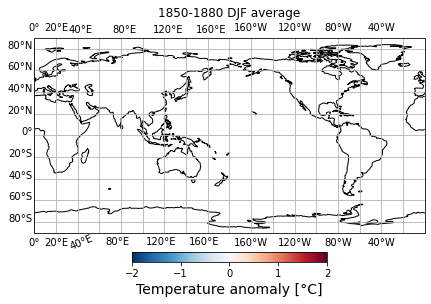

In [21]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_clim_glob.tmp.sel(season='DJF'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1850-1880 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_clim_tmp_DJF_Glob.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

In [18]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_clim_Aus.tmp.sel(season='DJF'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1850-1880 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_clim_tmp_DJF_Aus.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

NameError: name 'K_clim_Aus' is not defined

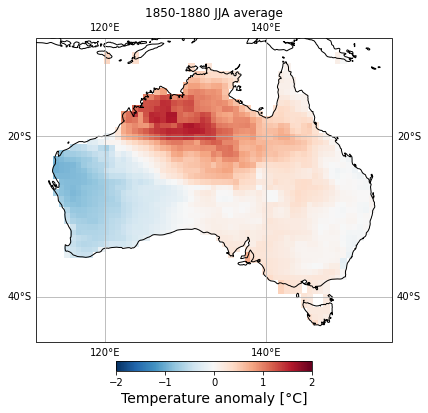

In [72]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_clim_Aus.tmp.sel(season='JJA'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1850-1880 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_clim_tmp_JJA_Aus.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

## 5 year average figures 

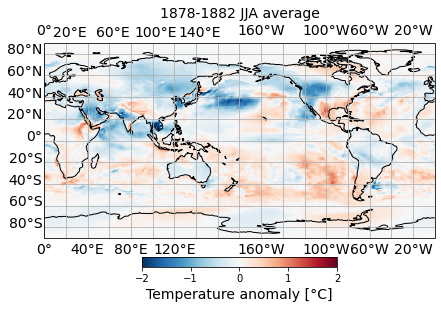

In [19]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tmp.sel(season='JJA'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_JJA_Glob.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

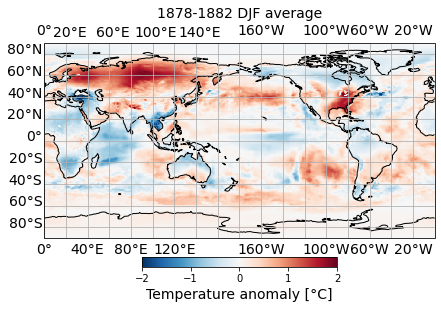

In [23]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tmp.sel(season='DJF'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_DJF_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

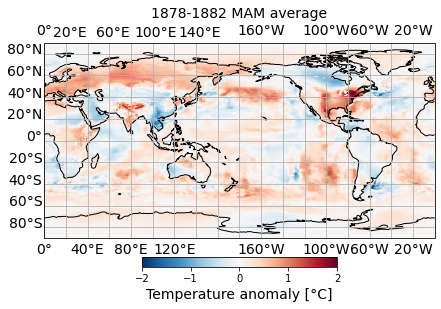

In [25]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tmp.sel(season='MAM'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 MAM average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_MAM_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

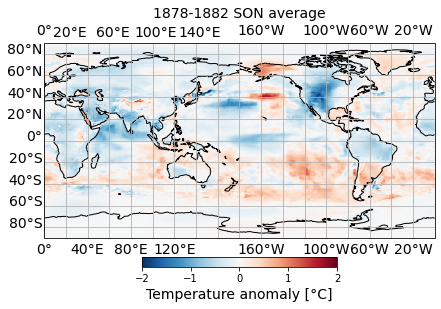

In [24]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tmp.sel(season='SON'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 SON average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_SON_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

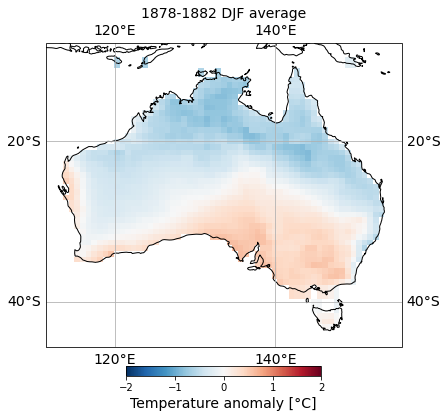

In [26]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.tmp.sel(season='DJF'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_DJF_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

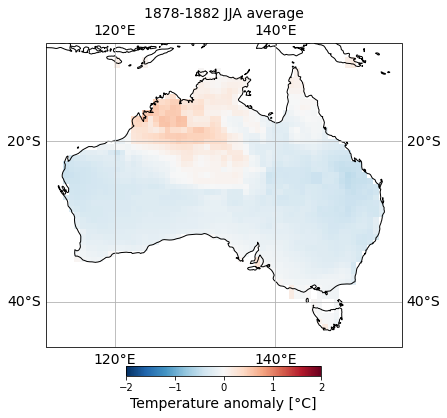

In [27]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.tmp.sel(season='JJA'), cmax_tmp, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_5yrm_tmp_JJA_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

# actual figures

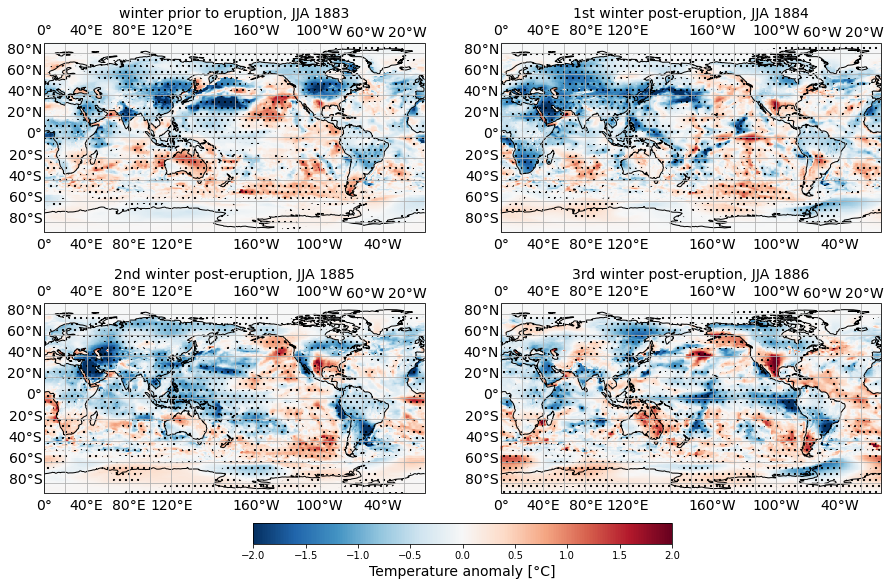

In [28]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tmp.sel(season='JJA'), cmax_tmp, K_dates_w, titles_w, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_JJA_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

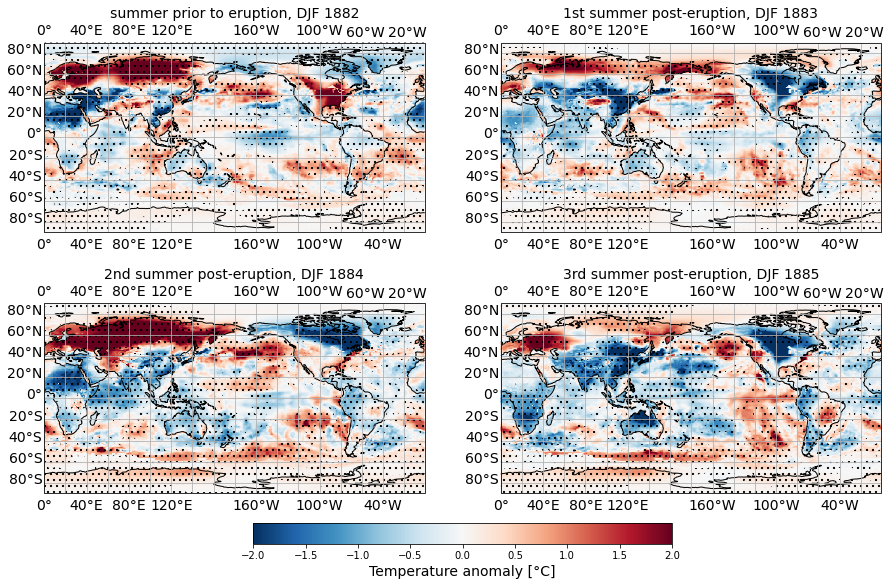

In [29]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tmp.sel(season='DJF'), cmax_tmp, K_dates_s, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_DJF_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

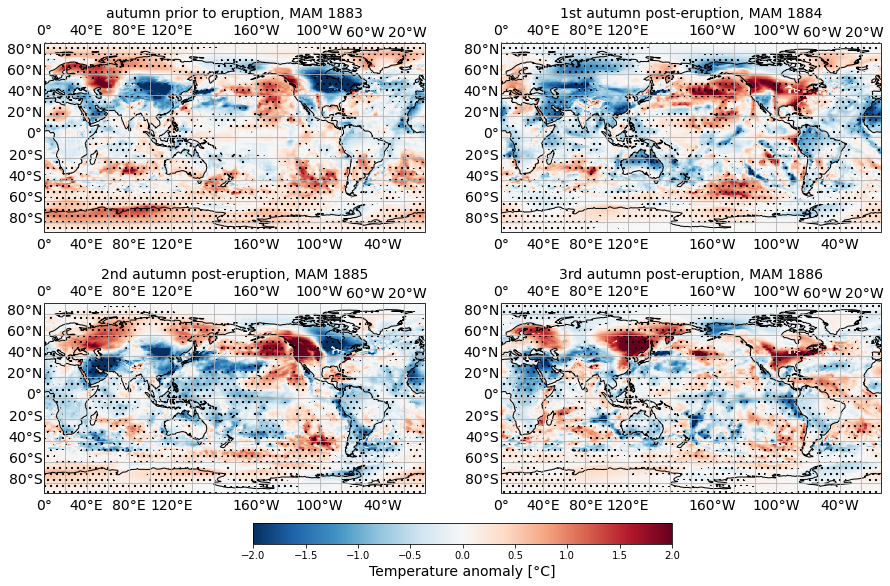

In [30]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tmp.sel(season='MAM'), cmax_tmp, K_dates_a, titles_a, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_MAM_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

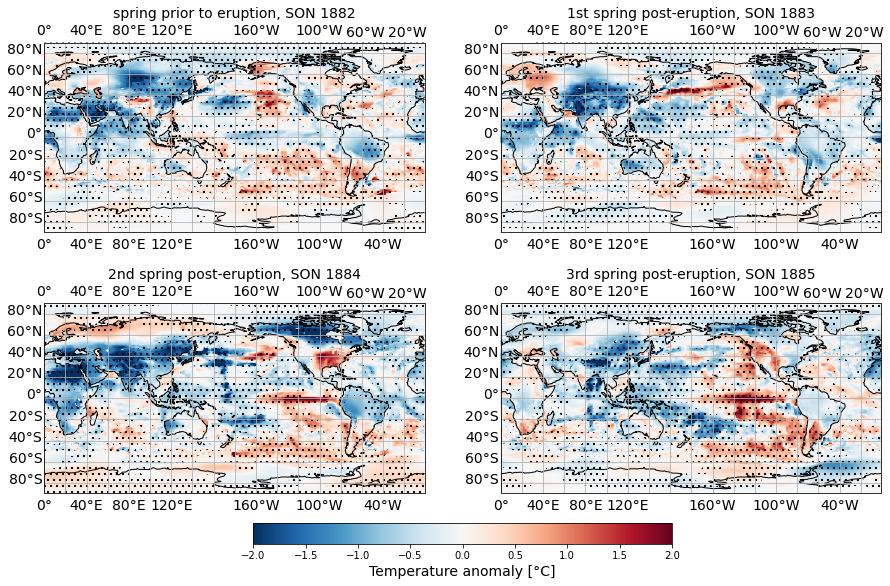

In [31]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tmp.sel(season='SON'), cmax_tmp, K_dates_sp, titles_sp, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_SON_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


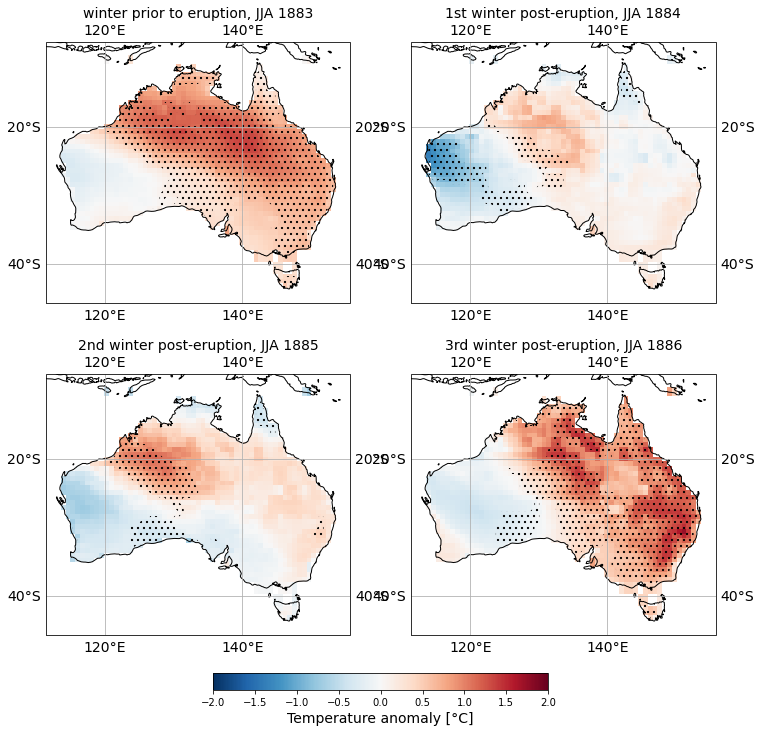

In [32]:
# plot of Aus monthly member mean temperature
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.tmp.sel(season='JJA'), cmax_tmp, K_dates_w, titles_w, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_JJA_Aus.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


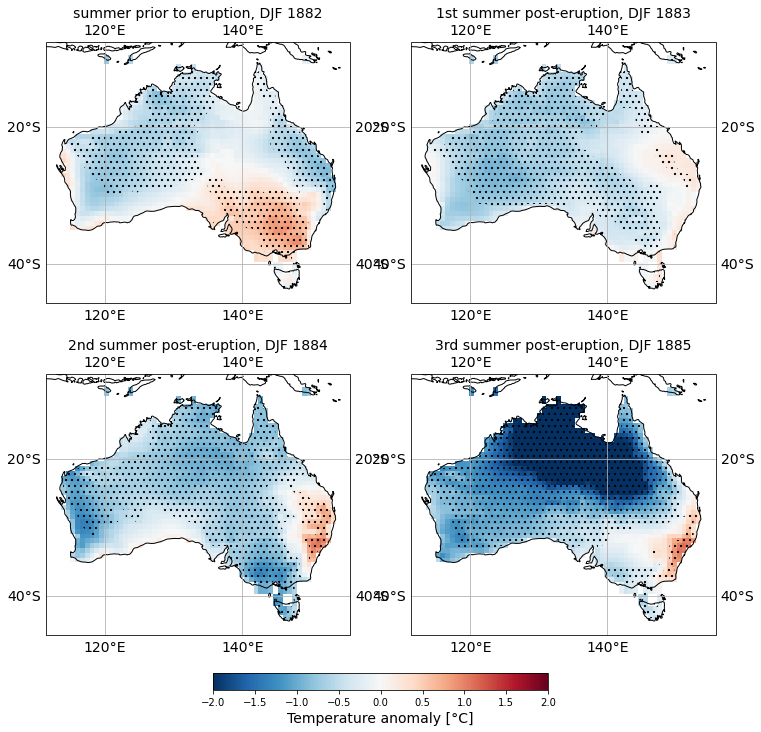

In [33]:
# plot of Aus monthly member mean temperature
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.tmp.sel(season='DJF'), cmax_tmp, K_dates_s, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmp_DJF_Aus.png', dpi=300, bbox_inches='tight')

In [81]:
# # plot of Aus monthly member mean precipitation
# fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

# fig.set_figwidth(12)
# fig.set_figheight(14) # these two parameters change the figure height and width 

# plt.savefig('R_spatial_pr_Aus.png', dpi=300, bbox_inches='tight')

## standard deviation oer time 

In [34]:
# calculate std as calculated in the graphs
std_Glob = K_mmm_mon_Glob.tmp.sel(seasonyear = slice('1850', '1881')).std(dim = ['seasonyear'])
std_Aus = K_mmm_mon_Aus.tmp.sel(seasonyear = slice('1850', '1881')).std(dim = ['seasonyear'])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [35]:
# select out jja and djf seasons and put into a list for plotting
std_Glob_data = [std_Glob.sel(season='JJA'), std_Glob.sel(season='DJF')]
std_Aus_data = [std_Aus.sel(season='JJA'), std_Aus.sel(season='DJF')]
dataset=[std_Glob.sel(season='JJA'), std_Glob.sel(season='DJF'), std_Aus.sel(season='JJA'), std_Aus.sel(season='DJF')]

In [78]:
def std_plot(rows, cols, dataset, cmax, titles, colours, units):
    fig = plt.figure()
    axs = []
    
    cmap = plt.get_cmap(f'{colours}', 5)
    
    for i, data in enumerate(dataset):    
        # Add a subplot with a projection    
        ax = fig.add_subplot(rows, cols, i+1, projection=ccrs.PlateCarree(180))        
        # We'll add a separate colour bar, but make sure all plots share the same min and max colour value  
        
        C = data.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap = cmap, vmin=cmax[0], vmax=cmax[1])
        # hatching where anomalies exceed a threshold of 2 standard deviations
   
        # axes
        ax.coastlines()
        # set the axis limits to be slihtly larger (2.5 degrees wither way) than the upper and lower bounds of the dataset 
        if (len(data.lon) < int(175/1.5)) & (len(data.lat) < int(175/1.5)):
            ax.set_extent([data.lon[0] - 2.5, data.lon[-1] + 2.5, data.lat[0] - 2.5, data.lat[-1] + 2.5], crs=ccrs.PlateCarree())
        # add on grid lines for longitude and latitude at specified range and spacing
        #ax.gridlines(xlocs=range(-180,181,20), ylocs=range(-80,81,20),draw_labels=False) 
        ax.gridlines(xlocs=range(-160,181,20), ylocs=range(-80,81,20),draw_labels=True)
        # add in different grid lines for tropics
        #tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
        #tropics.xlines=False
        # add titles for each subplot
        ax.set_title(titles[i])
        # Gather all axes for when we make the colour bar    
        axs.append(ax)    

    #Put the colour bar to the left of all axes
    cbar = plt.colorbar(C, orientation='vertical', ax=axs, shrink=0.5, pad=0.03)
#     cbar.ax.set_xlabel(f'{units}', fontsize=12, rotation='vertical', va='baseline', ha='left')
    cbar.ax.text(4.8, 0.15,f'{units}', fontsize=12, rotation=90)
    
    return fig

In [79]:
cmax_std = [0,1]

In [80]:
titles_Aus = ['Australia, JJA 1850-1880','Australia, DJF 1850-1880']
titles_std = ['Global, JJA 1850-1880','Global, DJF 1850-1880', 'Australia, JJA 1850-1880','Australia, DJF 1850-1880']

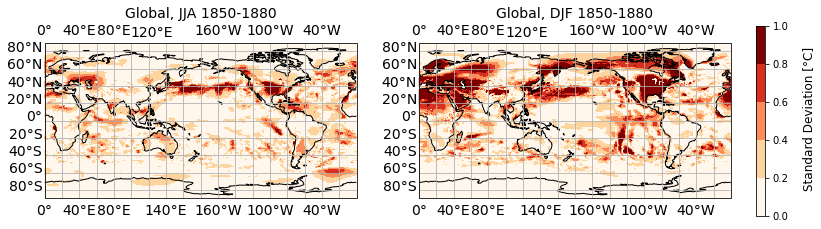

In [81]:
# plot of Global standard deviation
fig = std_plot(1, 2, std_Glob_data, cmax_std, titles_std, 'OrRd', f'Standard Deviation [{deg}C]')

fig.set_figwidth(15)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_std_tmp_DJF_Glob.png', dpi=300, bbox_inches='tight')

In [82]:
cmax_std = [0,0.5]

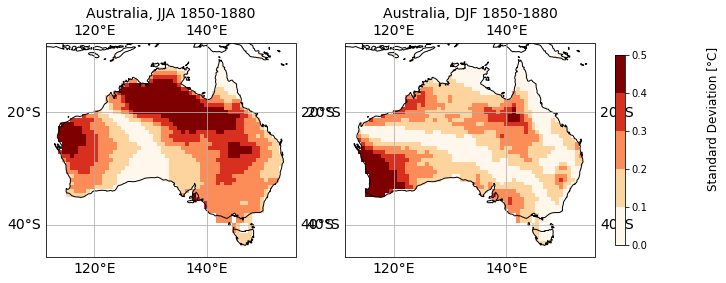

In [83]:
# plot of Global standard deviation
fig = std_plot(1, 2, std_Aus_data, cmax_std, titles_Aus, 'OrRd', f'Standard Deviation [{deg}C]')

fig.set_figwidth(12)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('R_spatial_std_tmp_DJF_Aus.png', dpi=300, bbox_inches='tight')